In [120]:
# don't change

REFERENCE_MISSION = 2

RESIZE_SCALE = 0.1

REFERENCE_CROP_L = 75
REFERENCE_CROP_R = 75
REFERENCE_CROP_T = 40
REFERENCE_CROP_B = 25

In [146]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from image_segmentation_info import *

In [115]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [116]:
def get_mission_segmentation_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '_segmentation\\mission_' + str(mission_number) + '_'

In [117]:
def plot_images(image_list, title_list=[], grid='off'):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [126]:
def load_images_and_masks(mission_number, is_mission_image, mask_type=''):
    if is_mission_image:
        result = cv2.imread(get_mission_segmentation_file_path(mission_number) + 'bordered.png')
        result = cv2.resize(result, (0,0), fx=RESIZE_SCALE, fy=RESIZE_SCALE)
        print('mission:', result.shape)
    else:
        if mask_type == 'REGIONS':
            file_name = 'region_mask_'
            print('Regions')
        elif mask_type == 'SAMPLES':
            file_name = 'sample_mask_'
            print('Samples')
        else:
            print('invalid mask type - REGIONS/SAMPLES')
            return -1

        result = dict()
        for name in REGION_NAMES:
            mask = np.load(get_mission_segmentation_file_path(mission_number) + file_name + name + '.npy').astype(np.uint8)*255
            mask = cv2.resize(mask, (0,0), fx=RESIZE_SCALE, fy=RESIZE_SCALE)
            print(name, ':', mask.shape)
            result[name] = mask

    return result

In [127]:
def calculate_masked_images(mission_image, masks):
    images = dict()
    for name in REGION_NAMES:
        image = cv2.bitwise_and(mission_image, mission_image, mask=masks[name])
        images[name] = image.astype(np.uint8)

    return images

In [169]:
def save_images_and_masks(mission_number, images, is_mission_image, filename):
    if is_mission_image:
        np.save(get_mission_file_path(mission_number) + filename + '.npy', images)
    else:
        for name in REGION_NAMES:
            np.save(get_mission_file_path(mission_number) + filename + '_%s.npy' % (name), images[name])

In [177]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def align_to_reference_helper(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

In [215]:
def align_to_reference(mission_number, images, is_mission_image):
    print('----')
    
    if mission_number == REFERENCE_MISSION:
        print('no alignment')

        # first time need to save the mission image because it'll be used for future alignments
        # check if reference is saved, if not then save here
#         NEED_TO_SAVE = not os.path.isfile(get_mission_file_path(REFERENCE_MISSION) + 'aligned_image.npy')  
#         print(NEED_TO_SAVE)
#         if NEED_TO_SAVE:
#             return -1 # need to run this with REFERENCE_MISSION first
        
        aligned_images = images
        if is_mission_image:
            h_ref, w_ref, _ = aligned_images.shape
        else:
            h_ref, w_ref = aligned_images['GRASS'].shape
    else:
        # perform alignment
        print('alignment')
        reference_mission = np.load(get_mission_file_path(REFERENCE_MISSION) + 'aligned_image.npy')
        h_ref, w_ref, c_ref = reference_mission.shape
        if is_mission_image:
            tobealigned_mission = images
            aligned_mission, H = align_to_reference_helper(tobealigned_mission, reference_mission)
            
            np.save(get_mission_file_path(mission_number) + 'H_from_mission_' + str(REFERENCE_MISSION) + '.npy', H)
            
            aligned_images = aligned_mission
            print(aligned_images.shape)
        else:
            H = np.load(get_mission_file_path(mission_number) + 'H_from_mission_' + str(REFERENCE_MISSION) + '.npy')
            # must be same shape, which it is. use same H
            
            aligned_images = dict()
            for name in REGION_NAMES:
                aligned_image = cv2.warpPerspective(images[name], H, (w_ref, h_ref))
                aligned_images[name] = aligned_image

    print('crop')
    
    if mission_number == REFERENCE_MISSION:
        if is_mission_image: # for global image
            result = copy.deepcopy(aligned_images)[REFERENCE_CROP_T:h_ref-REFERENCE_CROP_B, REFERENCE_CROP_L:w_ref-REFERENCE_CROP_R, :]
            print(result.shape)
        else: # for region and sample masks
            result = dict()

            for k, v in aligned_images.items():
                result[k] = copy.deepcopy(v)[REFERENCE_CROP_T:h_ref-REFERENCE_CROP_B, REFERENCE_CROP_L:w_ref-REFERENCE_CROP_R]
                print(result[k].shape)
        return result
    else:
        return aligned_images

# Start

In [236]:
mission_number = 4

mission_image = load_images_and_masks(mission_number, is_mission_image=True, mask_type='')
regions_mask = load_images_and_masks(mission_number, is_mission_image=False, mask_type='REGIONS')
samples_mask = load_images_and_masks(mission_number, is_mission_image=False, mask_type='SAMPLES')

mission: (670, 654, 3)
Regions
GRASS : (670, 654)
SIDEWALK : (670, 654)
BUILDING : (670, 654)
GRAVEL : (670, 654)
Samples
GRASS : (670, 654)
SIDEWALK : (670, 654)
BUILDING : (670, 654)
GRAVEL : (670, 654)


In [237]:
aligned_mission_image = align_to_reference(mission_number, mission_image, is_mission_image=True) # need to run this first to get homography matrix
aligned_regions_mask = align_to_reference(mission_number, regions_mask, is_mission_image=False)
aligned_samples_mask = align_to_reference(mission_number, samples_mask, is_mission_image=False)

----
alignment
(607, 528, 3)
crop
----
alignment
crop
----
alignment
crop


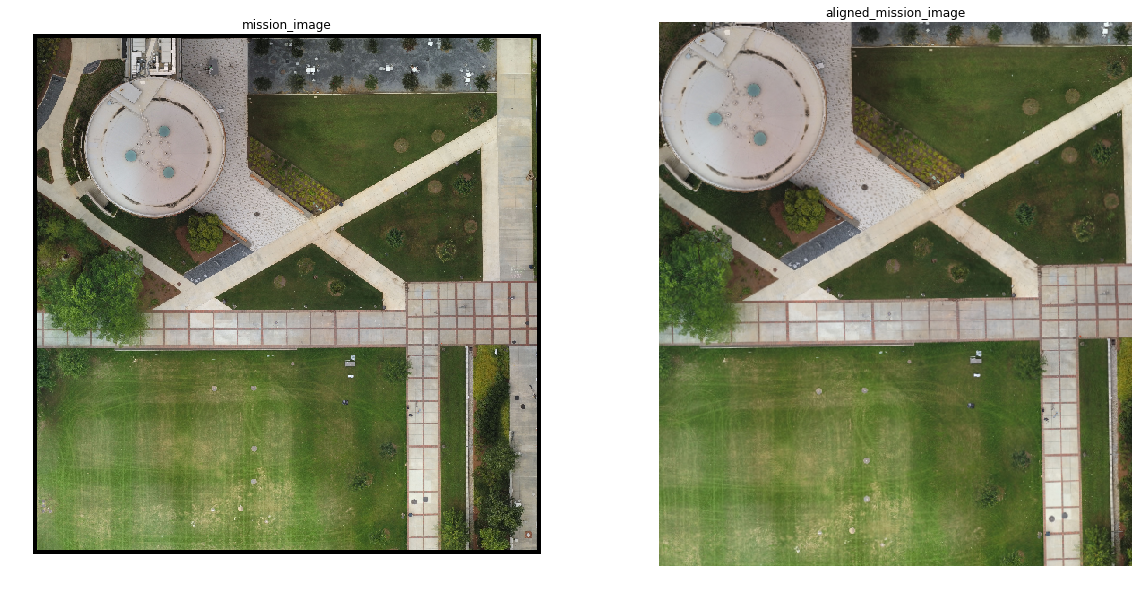

In [238]:
plot_images([mission_image, aligned_mission_image], ['mission_image', 'aligned_mission_image'])

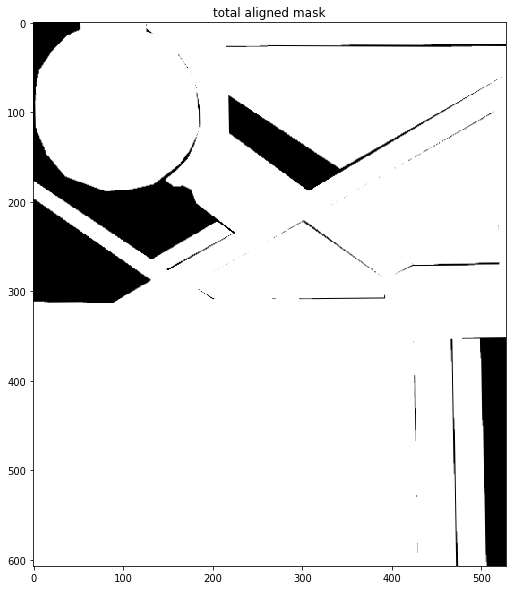

In [239]:
plot_images([cv2.bitwise_or(cv2.bitwise_or(aligned_regions_mask[REGION_NAMES[0]], aligned_regions_mask[REGION_NAMES[1]]), cv2.bitwise_or(aligned_regions_mask[REGION_NAMES[2]], aligned_regions_mask[REGION_NAMES[3]]))], ['total aligned mask'], grid='on')

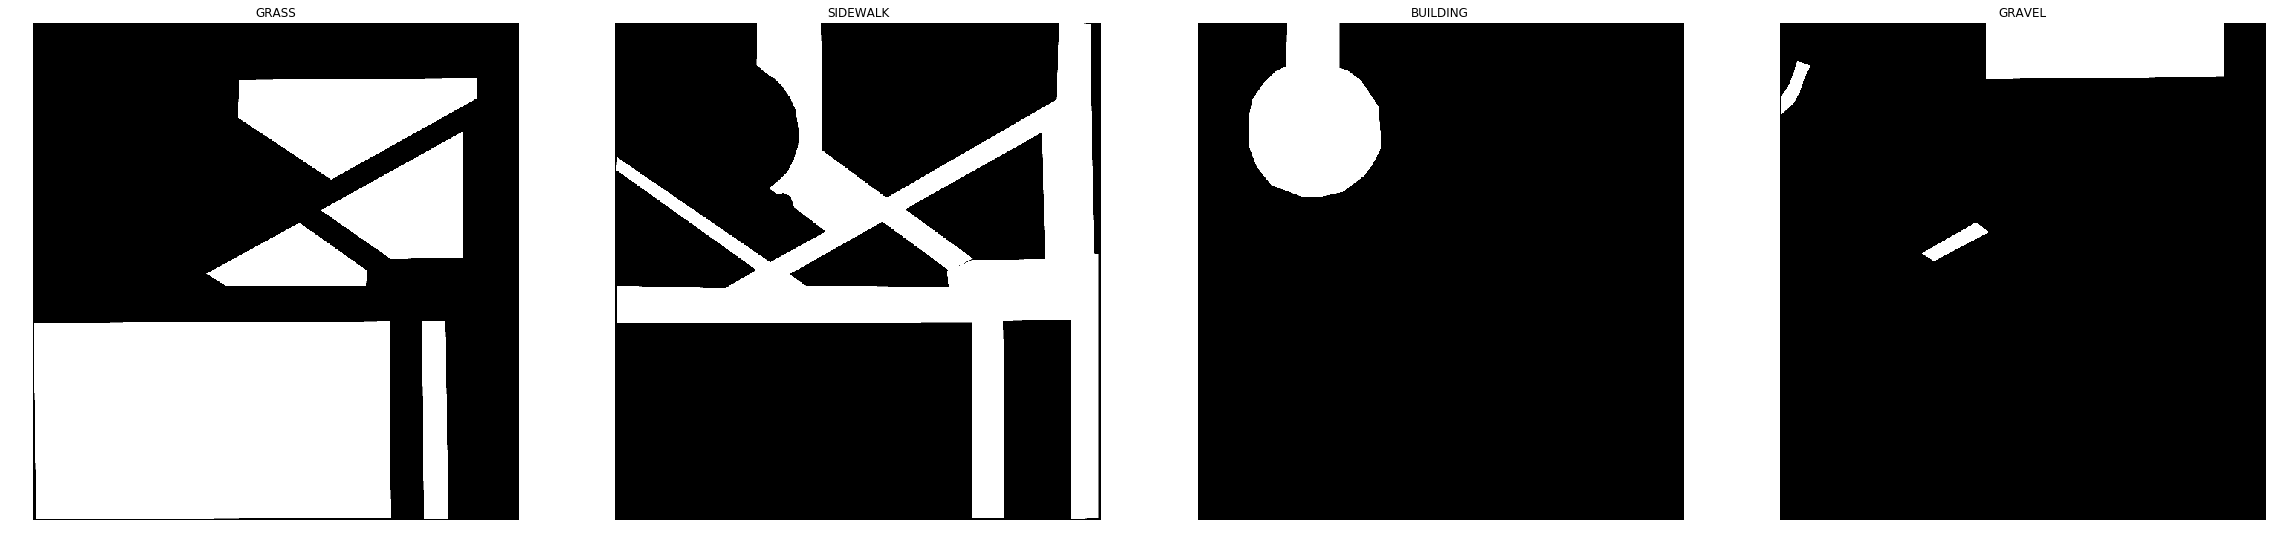

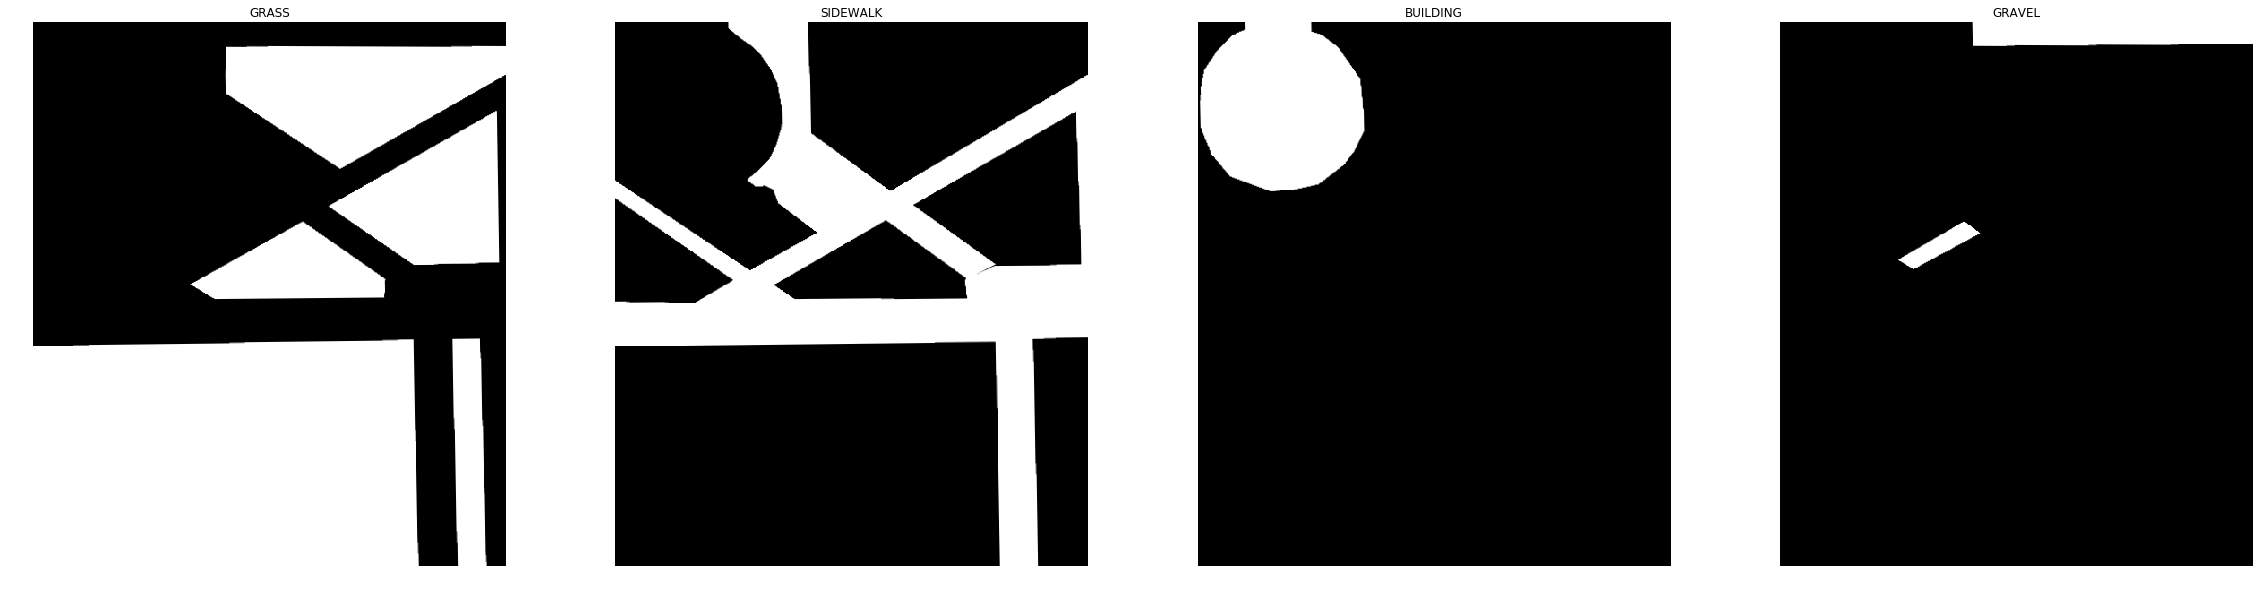

In [240]:
plot_images(list(regions_mask.values()), REGION_NAMES)
plot_images(list(aligned_regions_mask.values()), REGION_NAMES)

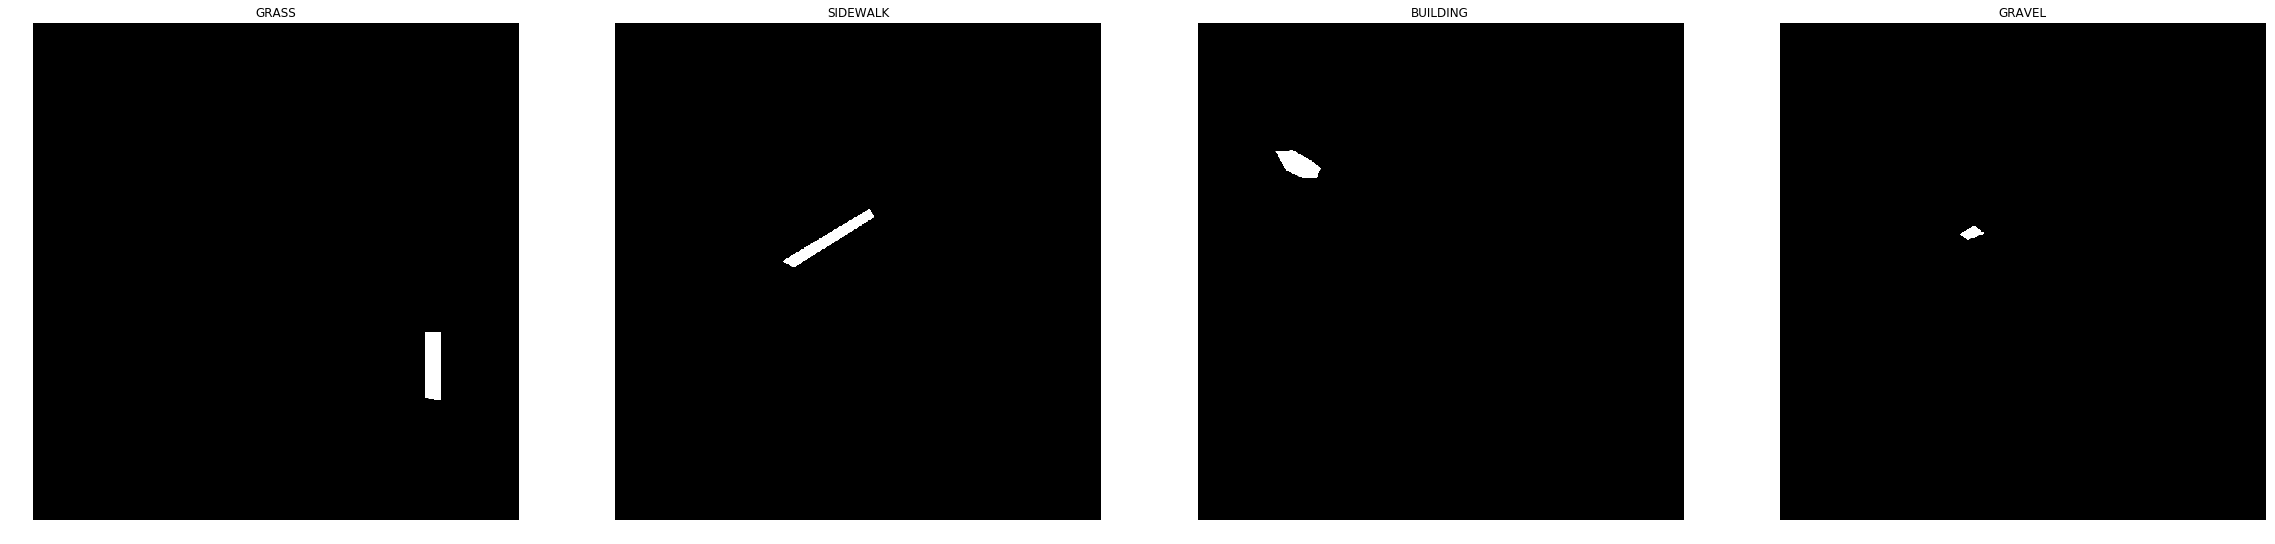

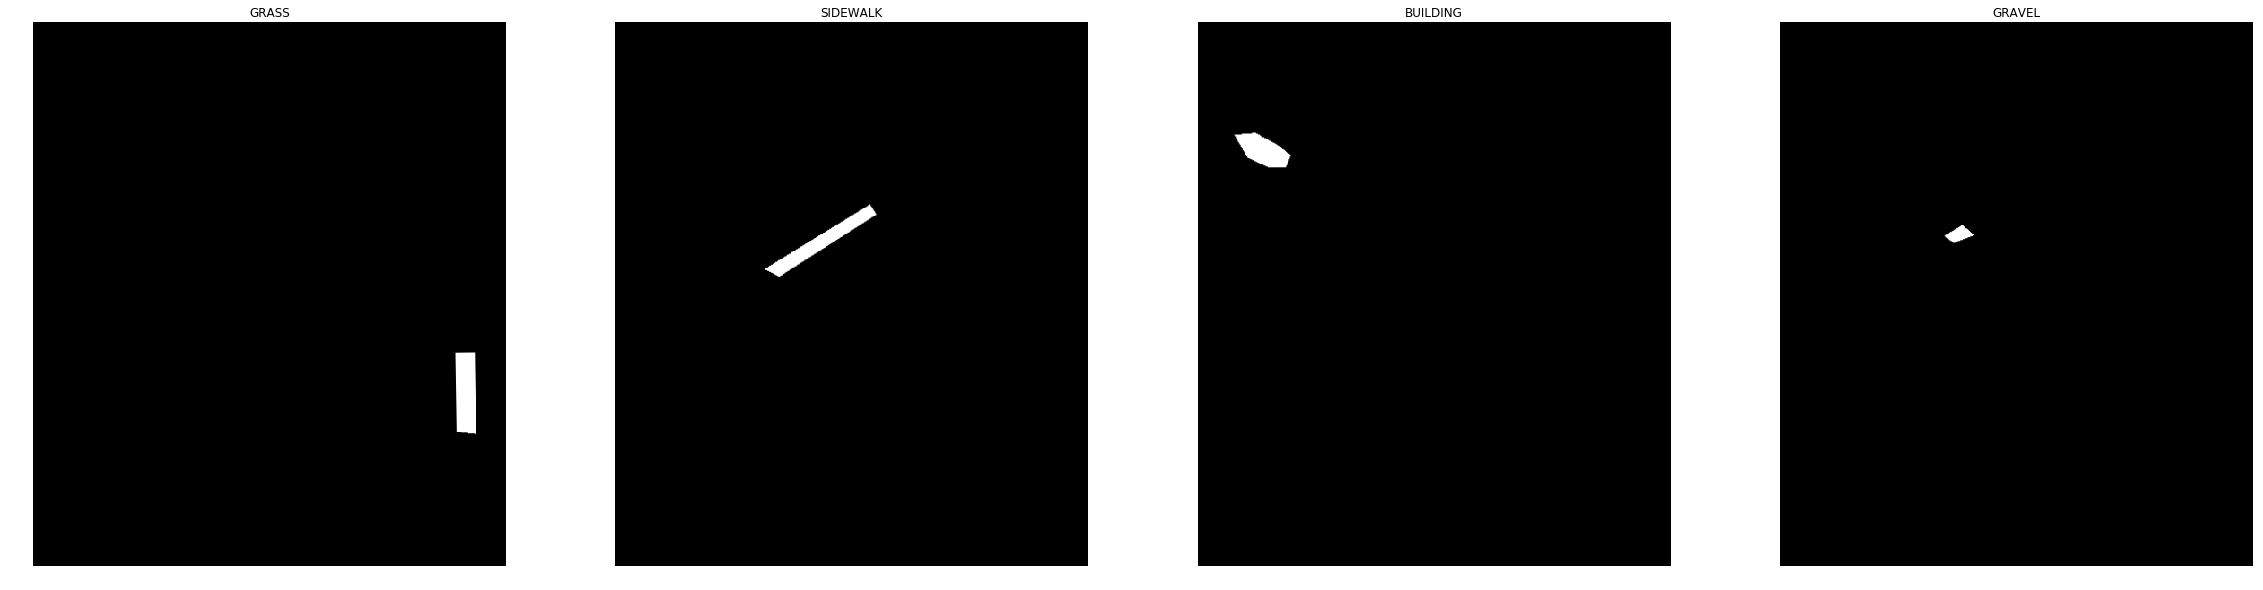

In [241]:
plot_images(list(samples_mask.values()), REGION_NAMES)
plot_images(list(aligned_samples_mask.values()), REGION_NAMES)

In [242]:
aligned_regions_image = calculate_masked_images(aligned_mission_image, aligned_regions_mask)
aligned_samples_image = calculate_masked_images(aligned_mission_image, aligned_samples_mask)

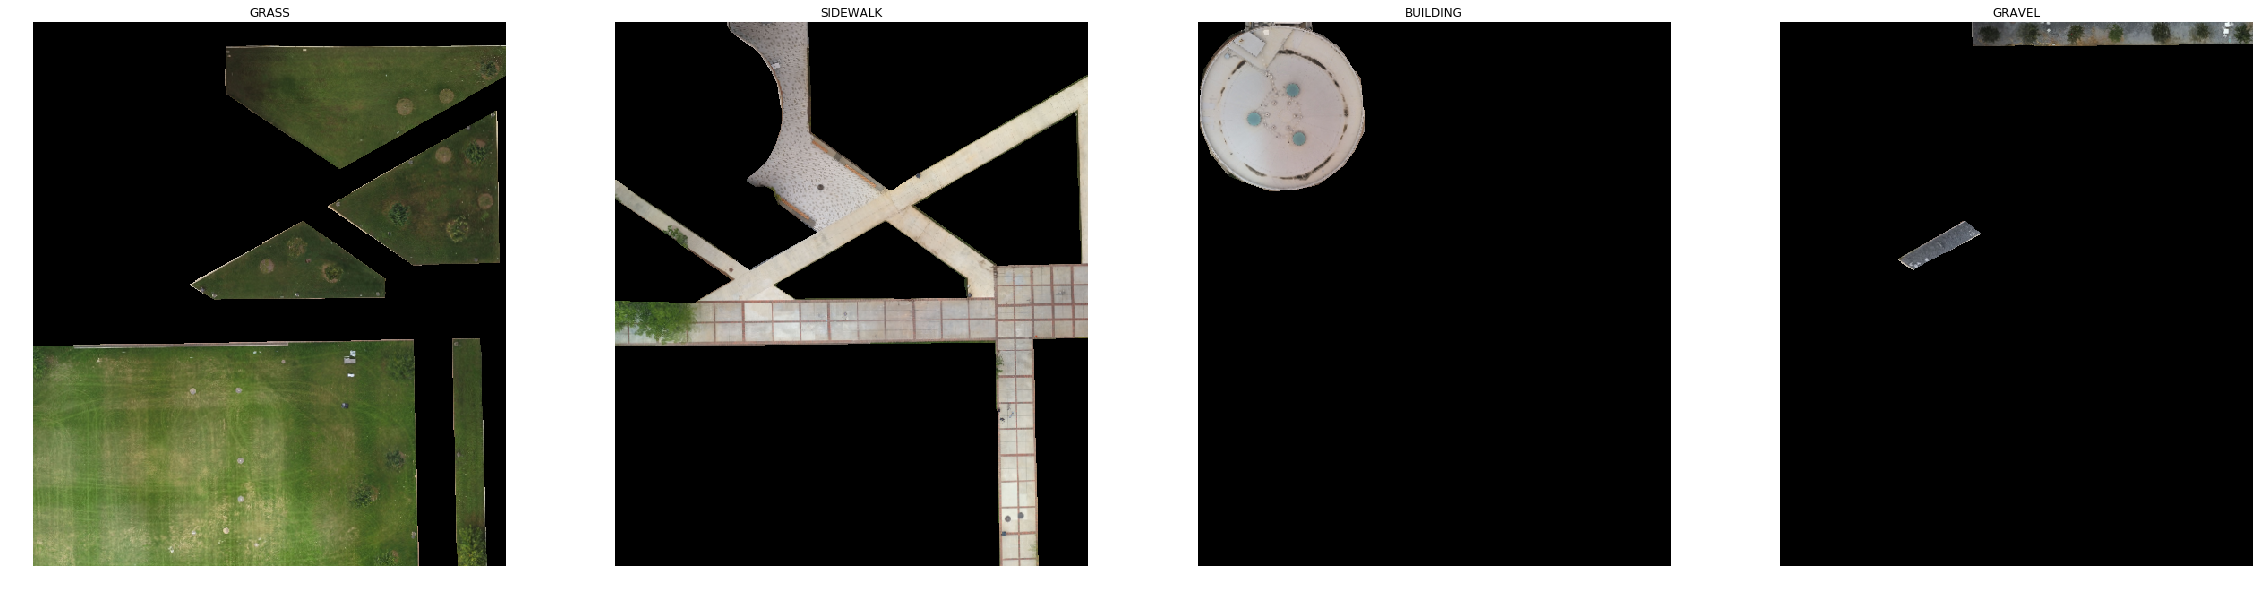

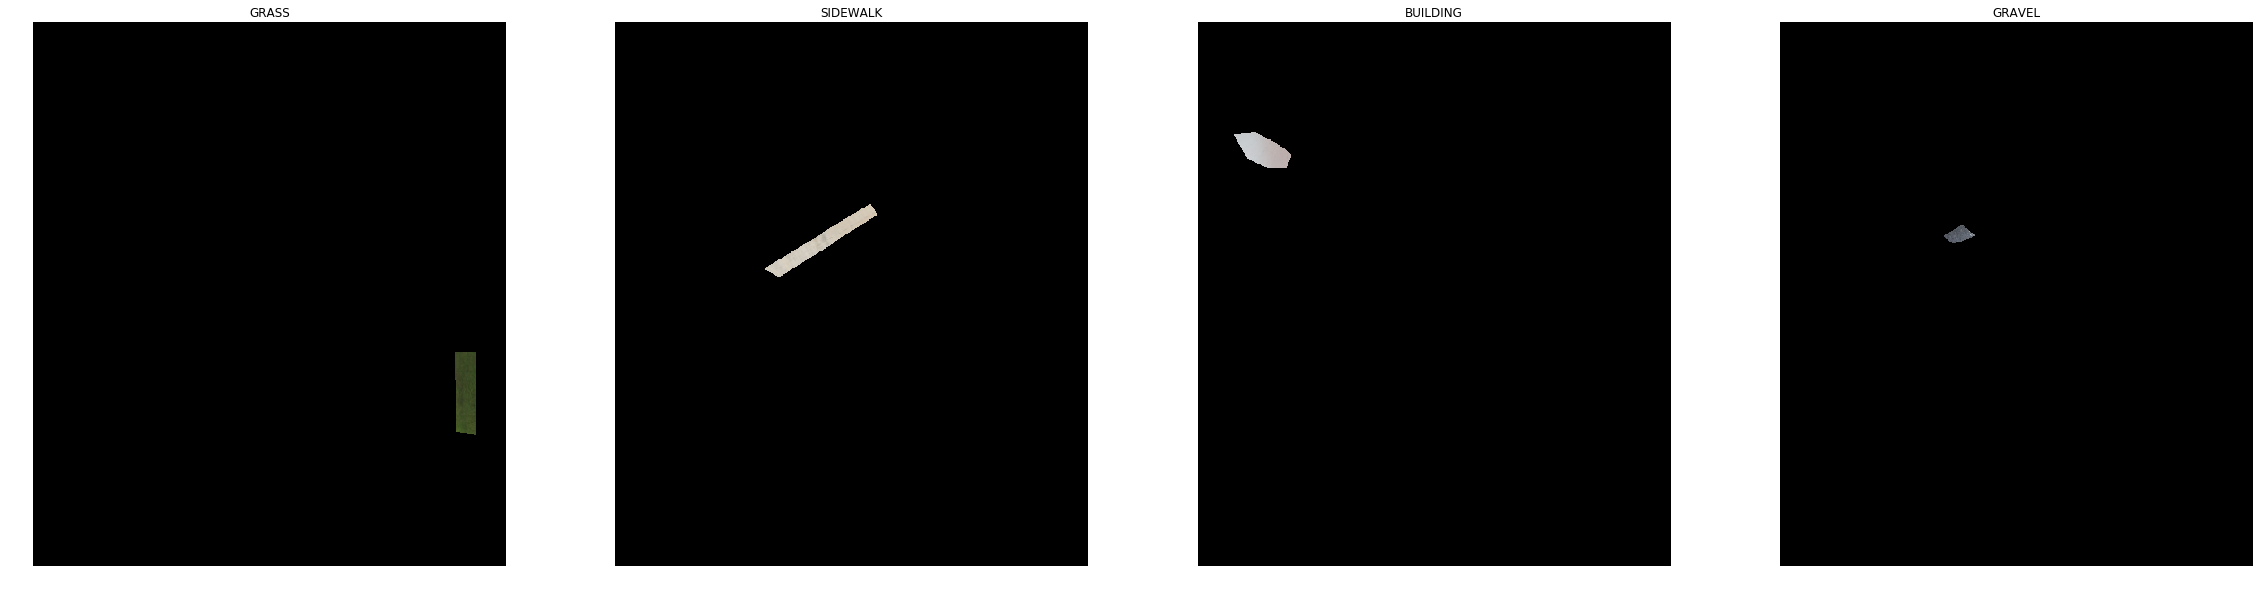

In [243]:
plot_images(list(aligned_regions_image.values()), REGION_NAMES)
plot_images(list(aligned_samples_image.values()), REGION_NAMES)

In [244]:
save_images_and_masks(mission_number, aligned_mission_image, is_mission_image=True, filename='aligned_image')
save_images_and_masks(mission_number, aligned_regions_image, is_mission_image=False, filename='region_aligned_image')
save_images_and_masks(mission_number, aligned_samples_image, is_mission_image=False, filename='sample_aligned_image')